# Production wire-scan data analysis
> 07.15.2021

In [1]:
import sys
import importlib
from pprint import pprint

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import proplot as plot
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sys.path.append('/Users/46h/Research/code/')
from accphys.tools import utils
from accphys.tools import beam_analysis as ba 
from accphys.tools import plotting as myplt
from accphys.tools.accphys_utils import V_matrix_4x4_uncoupled
from accphys.tools.accphys_utils import Sigma_from_twiss2D
from accphys.tools import emittance_measurement as em

In [2]:
plot.rc['grid.alpha'] = 0.04
plot.rc['figure.facecolor'] = 'white'

## Load data 

### Settings 

In [3]:
rec_node_id = 'Begin_Of_RTBT1'
# rec_node_id = 'Begin_Of_RTBT2'
# rec_node_id = 'RTBT_Diag:BPM19'
# rec_node_id = 'RTBT_Diag:WS20'
# rec_node_id = 'RTBT_Diag:BLM23'

In [15]:
ws_ids = ['RTBT_Diag:WS20', 'RTBT_Diag:WS21', 'RTBT_Diag:WS23', 'RTBT_Diag:WS24']

In [5]:
exp_twiss_filename = 'data/twiss/model_twiss_{}.dat'.format(rec_node_id)
transfer_matrices_filename = 'data/transfer_matrix/old/model_transfer_mat_elems_default_{}.dat'.format(rec_node_id)

Separate harp and wire-scanner files.

In [6]:
filenames = utils.list_files('./data/ws/')
filenames_ws = [filename for filename in filenames if not em.is_harp_file(filename)]
filenames_harp = [filename for filename in filenames if em.is_harp_file(filename)]

print('Wire-scanner files')
pprint(filenames_ws)
print('')
print('Harp files')
pprint(filenames_ws)

Wire-scanner files
['./data/ws/WireAnalysisFmt-2021.02.08_18.43.08.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_17.50.50.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.12_00.16.49.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.11_22.29.46.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_18.02.33.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.02_04.14.56.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.11_23.49.31.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.12_00.08.11.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.11_23.30.23.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_19.34.22.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_19.47.15.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_18.23.50.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_17.34.43.pta.txt']

Harp files
['./data/ws/WireAnalysisFmt-2021.02.08_18.43.08.pta.txt',
 './data/ws/WireAnalysisFmt-2021.02.08_17.50.50.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.12_00.16.49.pta.txt',
 './data/ws/WireAnalysisFmt-2021.05.11_22

### Harp 

These aren't used.

In [7]:
harp_profiles = [em.read_pta_harp(filename) for filename in filenames_harp]

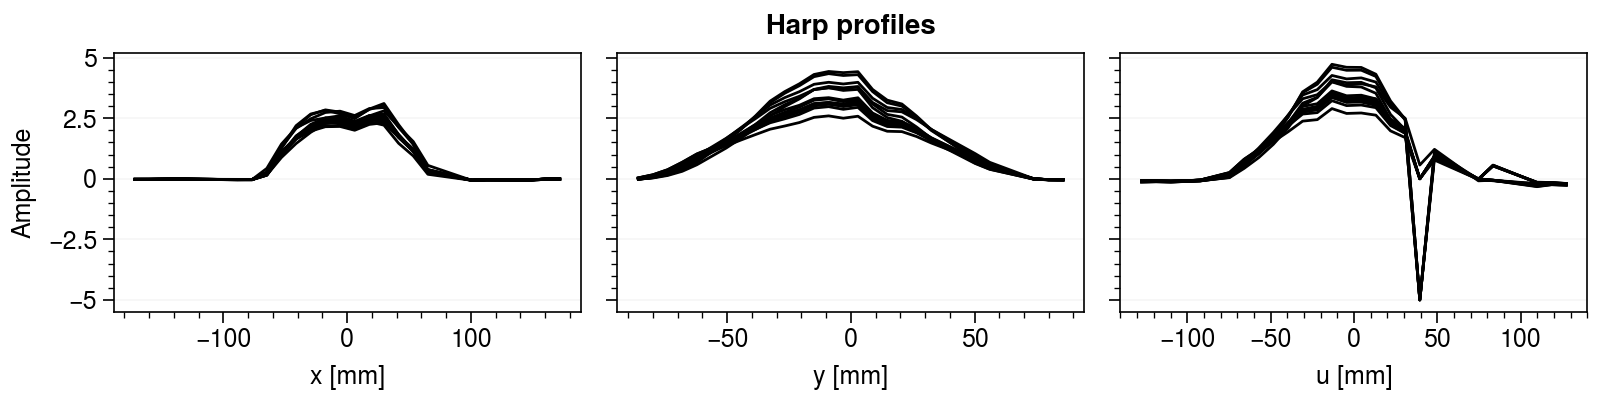

In [8]:
fig, axes = plot.subplots(ncols=3, figsize=(8, 2), spanx=False)
axes[0].set_xlabel('x [mm]')
axes[1].set_xlabel('y [mm]')
axes[2].set_xlabel('u [mm]')
axes[0].set_ylabel('Amplitude')
for profile in harp_profiles:
    signals = [profile.hor, profile.ver, profile.dia]
    for ax, signal in zip(axes, signals):
        ax.plot(signal.pos, signal.raw, marker=None, lw=1, color='k')
axes.grid(axis='x')
axes.format(suptitle='Harp profiles')

### Wire-scanners 

In [9]:
measurements = [em.Measurement(filename) for filename in filenames_ws]

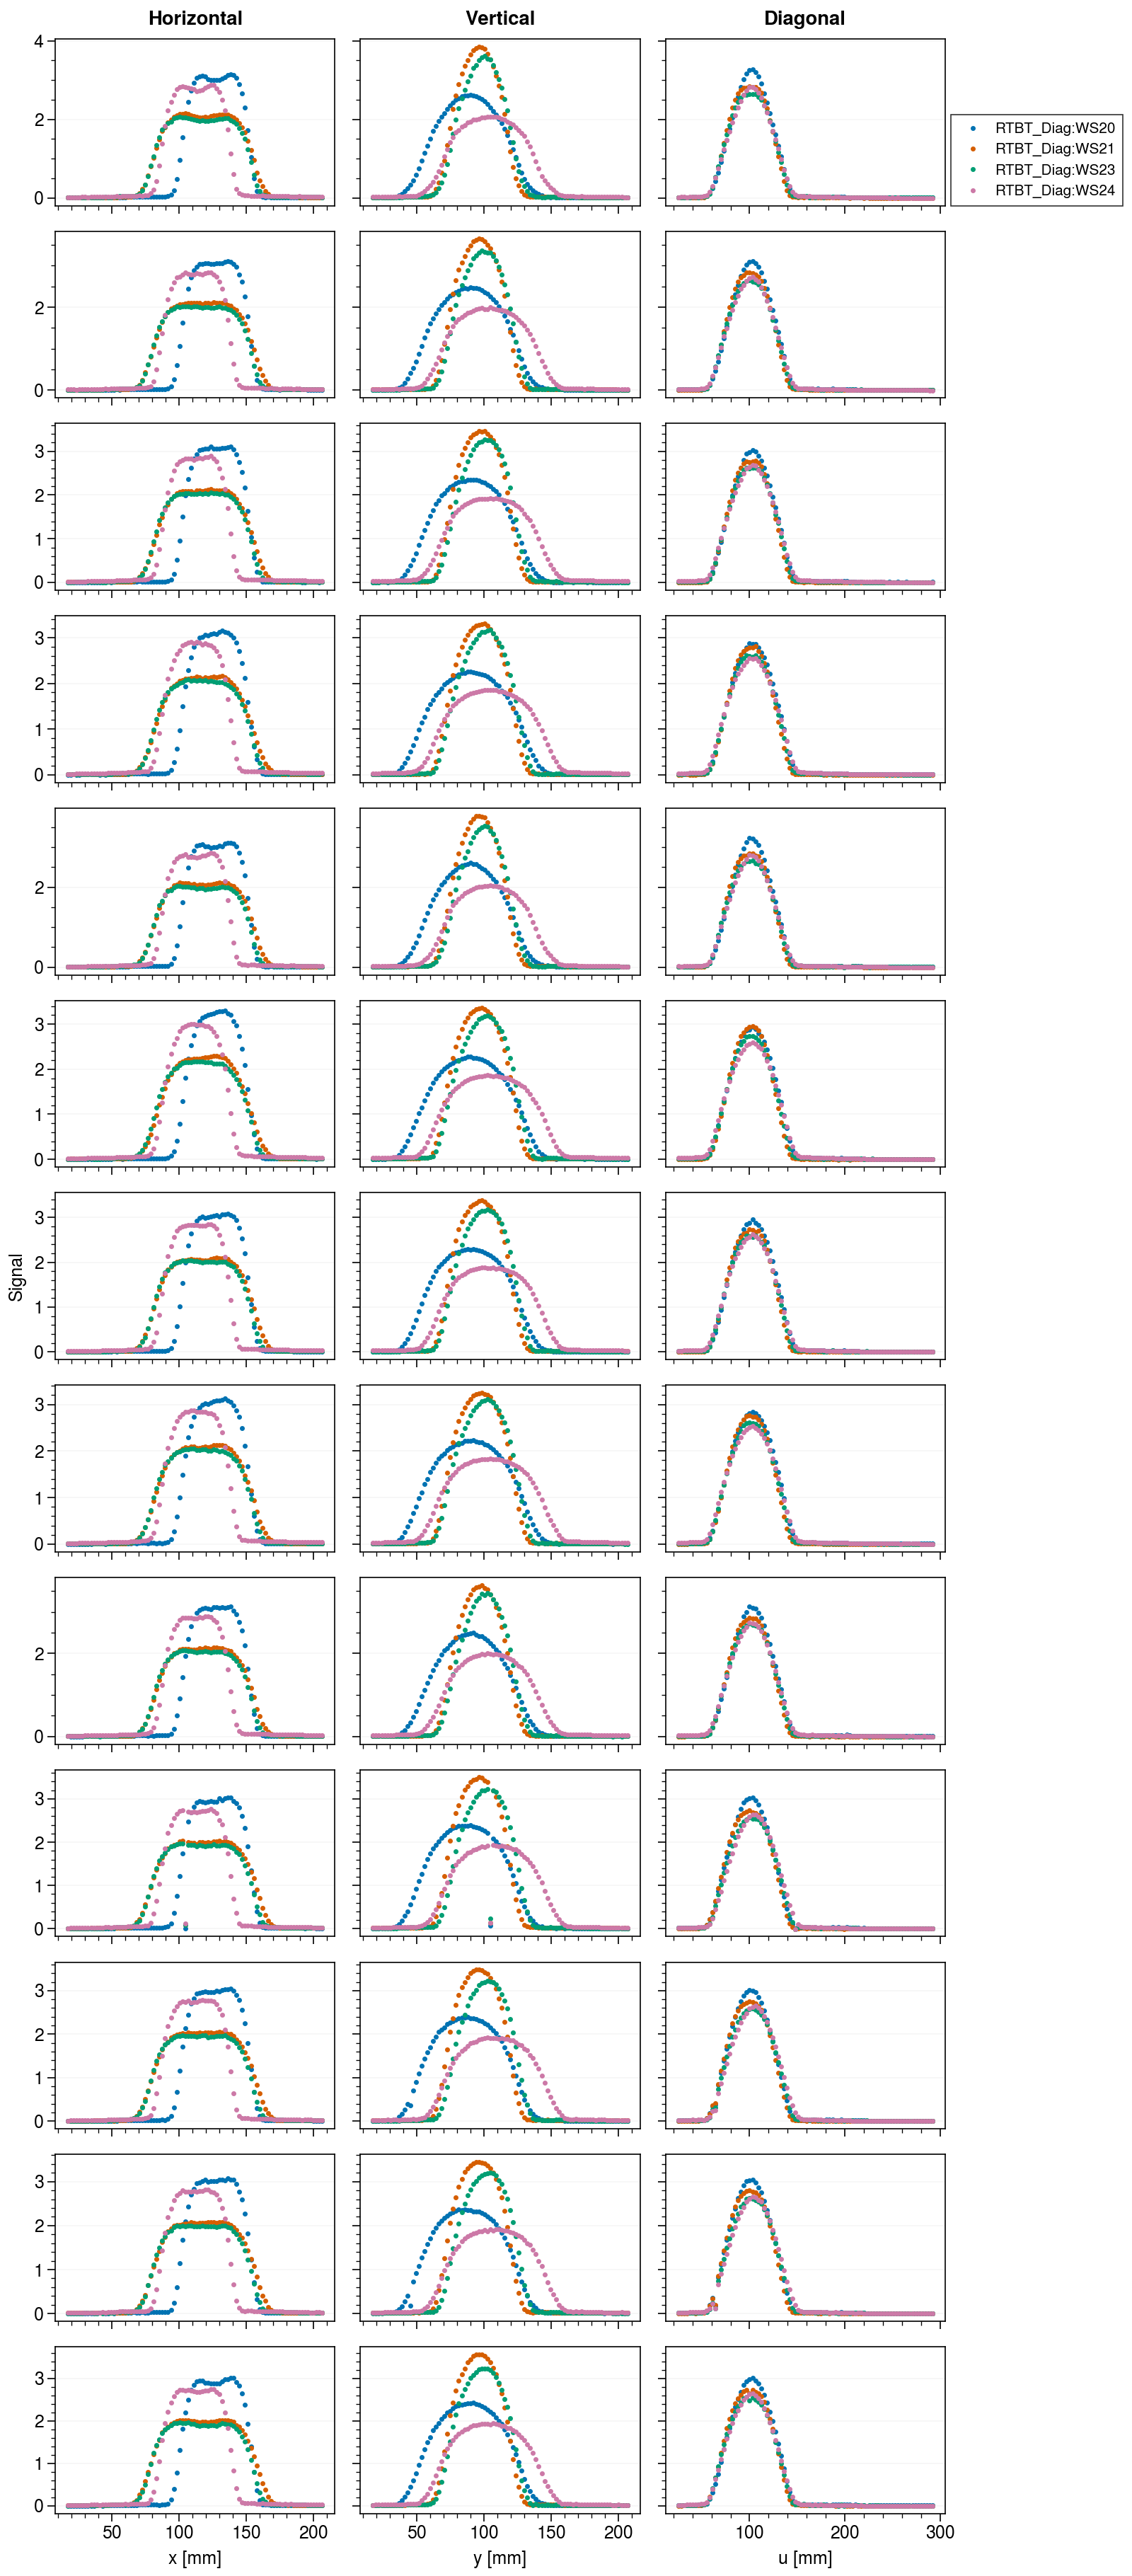

In [10]:
axes = em.plot_profiles(measurements, fit=False, kws_raw=dict(marker='.', ms=3, lw=0))
plt.savefig('figures/profiles.png', dpi=300, facecolor='white')

In [11]:
# kws_fit = dict(legend=False, color='k', alpha=0.2, zorder=0)
# axes = em.plot_profiles(measurements, ws_ids, fit=True, kws_raw=kws_raw, kws_fit=kws_fit)
# plt.savefig('figures/profiles_fit.png', dpi=300, facecolor='white')

## Reconstruct covariance matrix

Collect the measured beam moments at each wire-scanner.

In [12]:
diag_wire_angle = np.radians(-45.0)

In [16]:
moments = {ws_id: [] for ws_id in ws_ids}
for ws_id in ws_ids:
    for measurement in measurements:
        profile = measurement[ws_id]
        sig_xx = profile.hor.stats['Sigma'].rms**2
        sig_yy = profile.ver.stats['Sigma'].rms**2
        sig_uu = profile.dia.stats['Sigma'].rms**2
        sig_xy = em.get_sig_xy(sig_xx, sig_yy, sig_uu, diag_wire_angle)
        moments[ws_id].append([sig_xx, sig_yy, sig_xy])
    moments[ws_id] = np.array(moments[ws_id])

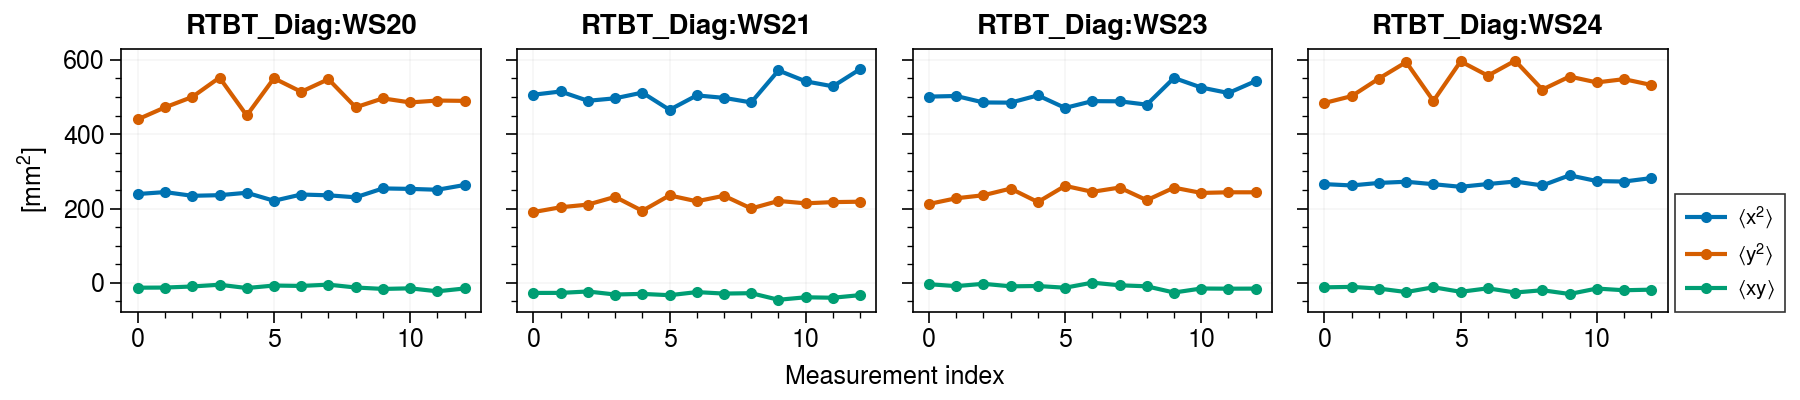

In [17]:
fig, axes = plot.subplots(ncols=4, figsize=(9, 2))
plt_kws = dict(marker='.')
for ws_id, ax in zip(ws_ids, axes):
    ax.plot(moments[ws_id][:, 0], **plt_kws)
    ax.plot(moments[ws_id][:, 1], **plt_kws)
    ax.plot(moments[ws_id][:, 2], **plt_kws)
axes.format(ylabel=r'[mm$^2$]', xlabel='Measurement index', toplabels=ws_ids)
ax.legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'],
          ncols=1, loc=(1.02, 0), fontsize='small')
plt.savefig('figures/moments.png', dpi=300, facecolor='white')

Collect the linear transfer matrices at each wire-scanner.

In [24]:
transfer_mats = {ws_id: [] for ws_id in ws_ids}
for i, ws_id in enumerate(ws_ids, start=1):
    for filename in filenames_ws:
        filename = 'data/transfer_matrix/model_transfer_mat_elems_default_Begin_Of_RTBT1_{}.dat'.format(filename.split('/')[-1]) 
        matrix_elements = np.loadtxt(filename)[i]
        transfer_mats[ws_id].append(matrix_elements.reshape((4, 4)))

Form list from dictionaries.

In [25]:
moments_list, transfer_mats_list = [], []
for ws_id in ws_ids:
    moments_list.extend(moments[ws_id])
    transfer_mats_list.extend(transfer_mats[ws_id])

Reconstruct the covariance matrix at the RTBT entrance.

In [26]:
Sigma = em.reconstruct(transfer_mats_list, moments_list, lsq_solver='exact',
                       verbose=2, lsmr_tol=1e-5)

The unconstrained solution is optimal.
Final cost 4.0490e+04, first-order optimality 1.24e-07


## Analysis 

In [27]:
alpha_x, alpha_y, beta_x, beta_y, eps_x, eps_y = ba.get_twiss2D(Sigma)
eps_1, eps_2 = ba.intrinsic_emittances(Sigma)

print('Sigma:')
print(Sigma)
print('eps_4D = {:.3f}'.format(np.sqrt(np.linalg.det(Sigma))))
print('eps_1, eps_2 = {:.3f}, {:.3f}'.format(eps_1, eps_2))
print('eps_x, eps_y = {:.3f}, {:.3f}'.format(eps_x, eps_y))
print('alpha_x, alpha_y = {:.3f}, {:.3f}'.format(alpha_x, alpha_y))
print('beta_x, beta_y = {:.3f}, {:.3f}'.format(beta_x, beta_y))

Sigma:
[[ 1.96640544e+02  4.21768358e+01 -5.26114391e+02  3.19933321e+01]
 [ 4.21768358e+01  1.52149378e+01 -9.75860113e+01 -4.35174460e-01]
 [-5.26114391e+02 -9.75860113e+01  3.51283585e+02 -2.38606995e+01]
 [ 3.19933321e+01 -4.35174460e-01 -2.38606995e+01  4.57747829e+00]]
eps_4D = 2137.179
eps_1, eps_2 = 91.710, 23.304
eps_x, eps_y = 34.828, 32.228
alpha_x, alpha_y = -1.211, 0.740
beta_x, beta_y = 5.646, 10.900


In [28]:
correlation_matrix = utils.cov2corr(Sigma)
print(correlation_matrix)

[[ 1.          0.77108521 -2.00177251  1.06637461]
 [ 0.77108521  1.         -1.33482259 -0.0521453 ]
 [-2.00177251 -1.33482259  1.         -0.59503306]
 [ 1.06637461 -0.0521453  -0.59503306  1.        ]]


In [29]:
coupling_coeff = 1.0 - np.sqrt((eps_1 * eps_2) / (eps_x * eps_y))
print('Coupling coefficient = {}'.format(coupling_coeff))

Coupling coefficient = -0.3798692926672427


Below are the rms ellipses defined by the covariance matrix. The cross-plane projections are squares in reality.

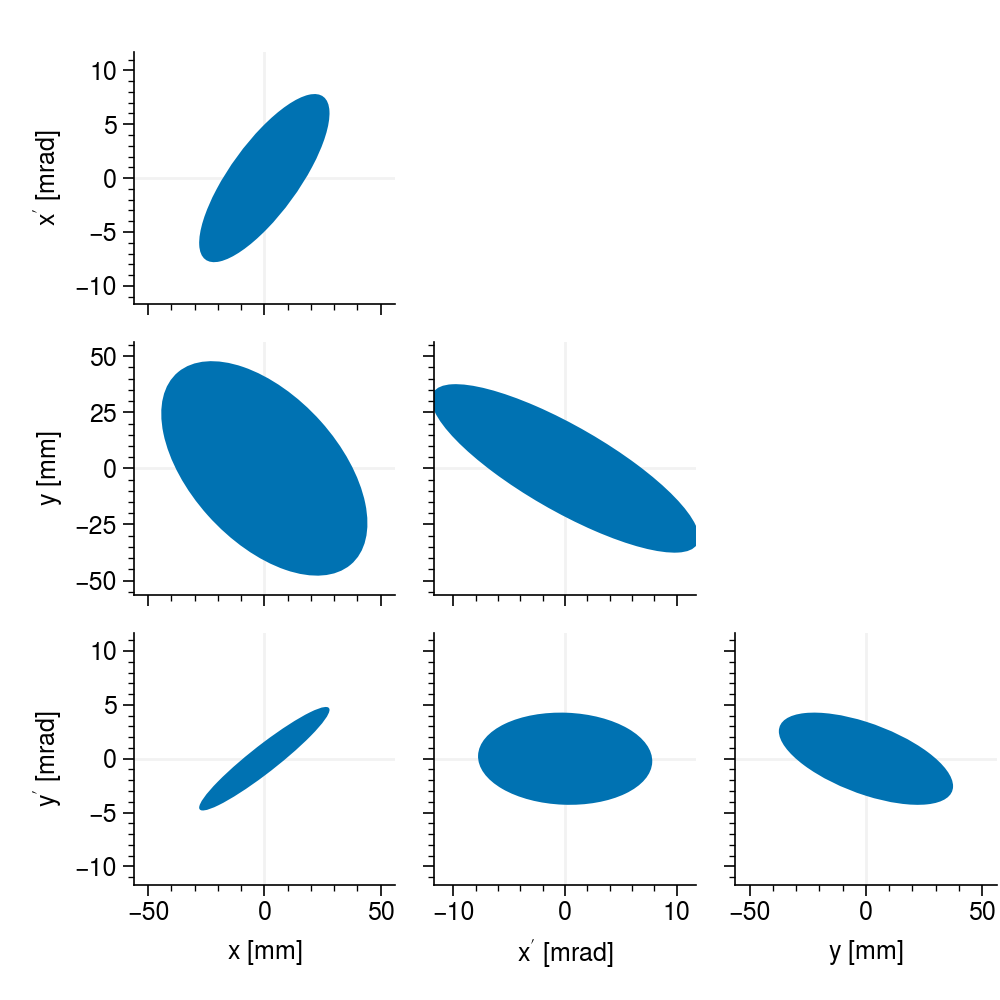

In [30]:
axes = myplt.rms_ellipses(Sigma, fill=True)
for i in range(3):
    for j in range(i + 1):
        kws = dict(lw=1, alpha=0.05, color='k', zorder=0)
        ax = axes[i, j]
        ax.axvline(0, **kws)
        ax.axhline(0, **kws)
        ax.grid(False)
plt.savefig('figures/rms_ellipses.png', dpi=300, facecolor='white');

Expected covariance matrix at RTBT entrance (from default optics).

In [31]:
twiss_exp = np.loadtxt(exp_twiss_filename)
alpha_x_exp, alpha_y_exp, beta_x_exp, beta_y_exp = twiss_exp
print('alpha_x_exp, alpha_y_exp = {:.3f}, {:.3f}'.format(alpha_x_exp, alpha_y_exp))
print('beta_x_exp, beta_y_exp = {:.3f}, {:.3f}'.format(beta_x_exp, beta_y_exp))
Sigma_exp = Sigma_from_twiss2D(alpha_x_exp, alpha_y_exp, beta_x_exp, beta_y_exp, eps_x, eps_y)

alpha_x_exp, alpha_y_exp = -1.249, 0.784
beta_x_exp, beta_y_exp = 5.831, 10.017


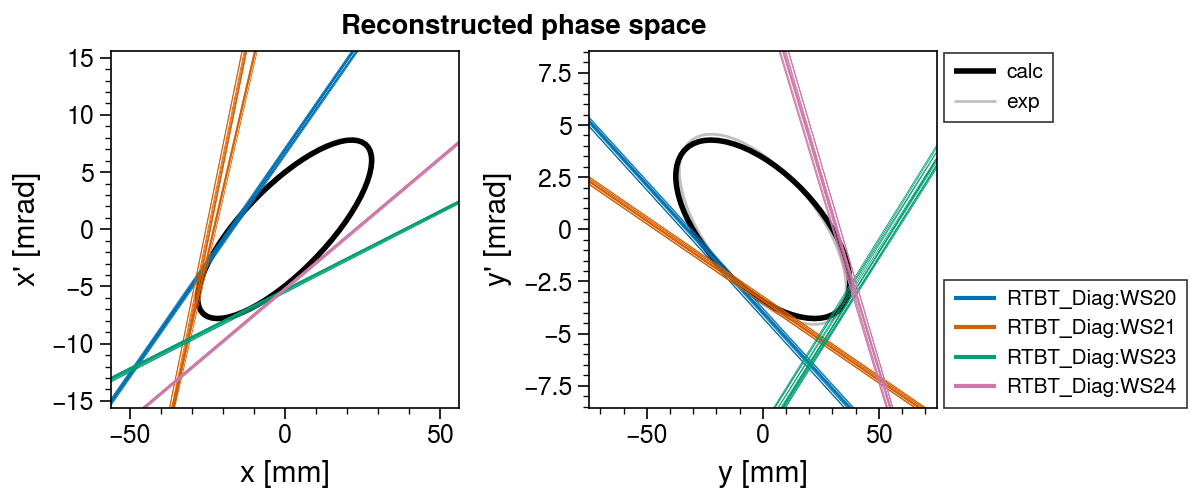

In [32]:
axes = em.plot_reconstructed_phasespace(transfer_mats, moments, Sigma, Sigma_exp)
axes.format(suptitle='Reconstructed phase space')
plt.savefig('figures/lines.png', dpi=300, facecolor='white')

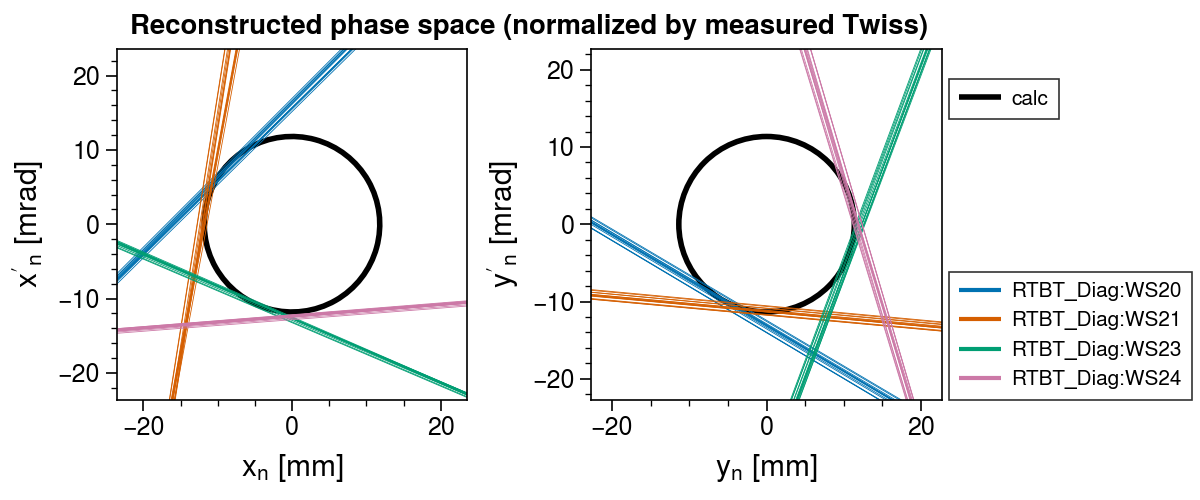

In [33]:
axes = em.plot_reconstructed_phasespace(transfer_mats, moments, 
                                        Sigma, Sigma_exp=None, 
                                        twiss=(alpha_x, alpha_y, beta_x, beta_y))
axes.format(suptitle='Reconstructed phase space (normalized by measured Twiss)')
plt.savefig('figures/lines_norm.png', dpi=300, facecolor='white')

### Comparison 

In [45]:
def solve(lsq_solver):
    Sigma = em.reconstruct(transfer_mats_list, moments_list, verbose=0, lsq_solver=lsq_solver)
    eps_x, eps_y = ba.apparent_emittances(Sigma)
    eps_1, eps_2 = ba.intrinsic_emittances(Sigma)
    return eps_x, eps_y, eps_1, eps_2

def get_moments(n_meas):
    """Use `n_meas` measurements from each wire-scanner."""
    moments_list = []
    for measurement in measurements[:n_meas]:
        for ws_id in ws_ids:
            profile = measurement[ws_id]
            sig_xx = profile.hor.stats['Sigma'].rms**2
            sig_yy = profile.ver.stats['Sigma'].rms**2
            sig_uu = profile.dia.stats['Sigma'].rms**2
            sig_xy = em.get_sig_xy(sig_xx, sig_yy, sig_uu, diag_wire_angle)
            moments_list.append([sig_xx, sig_yy, sig_xy])
    return moments_list

def get_transfer_mats(n_meas):
    """Get transfer matrix for each measurement."""
    transfer_mats_list = []
    for filename in filenames_ws[:n_meas]:
        filename = 'data/transfer_matrix/model_transfer_mat_elems_default_Begin_Of_RTBT1_{}.dat'.format(filename.split('/')[-1]) 
        for elements, ws_id in zip(np.loadtxt(filename), ['WS02', 'WS20', 'WS21', 'WS23', 'WS24']):
            if ws_id != 'WS02': # don't have data from this wire-scanner
                transfer_mats_list.append(elements.reshape(4, 4))
    return transfer_mats_list

In [46]:
results = dict()
for lsq_solver in ['exact', 'lsmr']:
    data = []
    for n_meas in range(1, len(filenames_ws)):
        moments_list = get_moments(n_meas)
        transfer_mats_list = get_transfer_mats(n_meas)
        data.append(solve(lsq_solver))
    results[lsq_solver] = np.array(data)

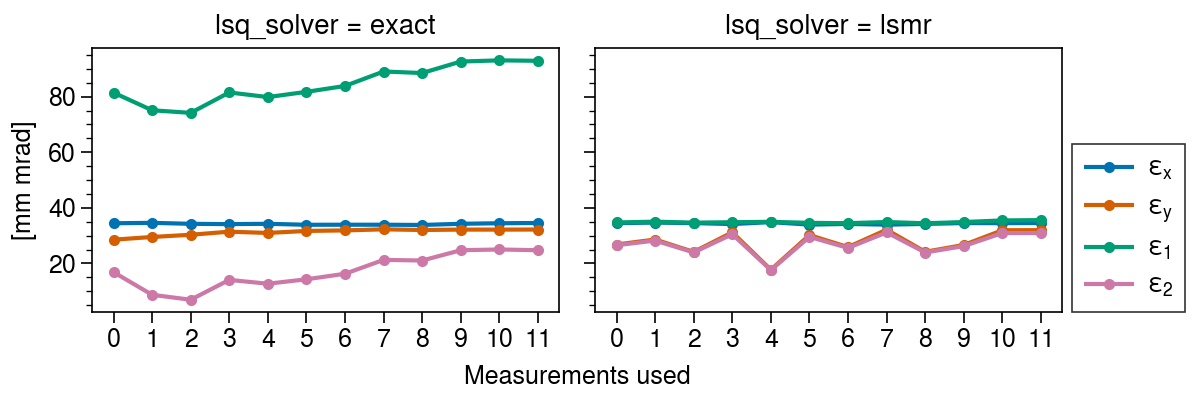

In [47]:
fig, axes = plot.subplots(ncols=2, figsize=(6, 2))
for ax, key in zip(axes, ['exact', 'lsmr']):
    ax.plot(results[key], marker='.')
    ax.set_title('lsq_solver = ' + key)
axes.format(xlabel='Measurements used', ylabel='[mm mrad]', grid=False, 
            xticks=range(0, len(filenames_ws)), xtickminor=False)
axes[1].legend(labels=[r"$\varepsilon_{}$".format(s) for s in ['x', 'y', '1', '2']], 
               ncols=1, loc=(1.02, 0))
plt.savefig('figures/comparison.png', dpi=300, facecolor='white')